In [101]:
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
from sklearn.metrics import accuracy_score
import wandb


### Fashion Mnist Dataset

In [102]:
(X, Y), (X_test, Y_test) = fashion_mnist.load_data()

### Question 1

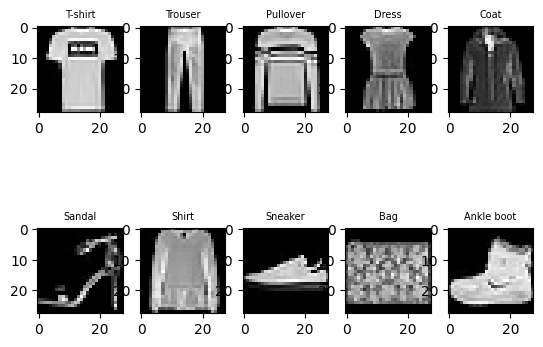

In [103]:
num_classes = len(np.unique(Y))
# for i in range(num_classes):
unique_classes = [X[np.where(Y == i)[0][0]] for i in range(num_classes)]
class_names = ["T-shirt", "Trouser", "Pullover", "Dress",
               "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
for i in range(1, num_classes+1):
    plt.subplot(2, 5, i)
    plt.imshow(unique_classes[i-1], cmap=plt.get_cmap('gray'))
    plt.title(class_names[i-1], fontdict={'fontsize': 7})
plt.show()


### Data Cleaning

In [104]:
num_features = np.shape(X)[1]*np.shape(X)[2]
X = X.reshape(np.shape(X)[0], 784)
X_test = X_test.reshape(np.shape(X_test)[0], 784)
X_train, Xv, Y_train, Yv = sklearn.model_selection.train_test_split(
    X, Y, test_size=0.1, random_state=4, shuffle=True)
print("Size of Training DataSet =", len(X_train))
print("Size of Validation DataSet =", len(Xv))
print("Size of Test DataSet =", len(X_test))
print("Number of classes =", num_classes)
print("Number of features =", num_features)
X_train = X_train.T
Xv = Xv.T
X_test = X_test.T


Size of Training DataSet = 54000
Size of Validation DataSet = 6000
Size of Test DataSet = 10000
Number of classes = 10
Number of features = 784


### Activation Functions

In [105]:
def sigmoid(x):
    return 1. /(1. + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0,x)

def der_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def der_tanh(x):
    return 1-(np.tanh(x)**2)

def der_relu(x):
    return (x>0)*1

def softmax(x):
    return (np.exp(x)/np.sum(np.exp(x),axis = 0))

def der_softmax(x):
    return softmax(x) * (1-softmax(x))

### Forward Propagation and Back Propagation

In [106]:
class Parameters:
    def __init__(self):
        # self.weight_initializers = {"random": self.random_initialization, "xavier": self.xavier_intialization}
        
        pass
    
    def ForwardPropagation(self,X):
        W = self.W
        b = self.b
        A = [None]*len(W)
        H = [None]*len(b)
        for i in range(len(W)):
            if i == 0:
                A[i] = b[i] + W[i]@X
            else:
                A[i] = b[i] + W[i]@H[i-1]
            if i == len(W) - 1:
                H[i] = self.output_activation(A[i])
            else:
                H[i] = self.activation(A[i])
        self.A = A
        self.H = H
    
    def BackPropagation(self,X,Y):
        W = self.W
        b = self.b
        A = self.A
        H = self.H
        grad_a = [None]*len(A)
        grad_h = [None]*len(H)
        grad_w = [None]*len(W)
        grad_b = [None]*len(b)
        N = len(W)
        Y_hat = H[len(H)-1]
        grad_a[N-1] = Y_hat - Y
        
        for i in range(N-1,-1,-1):
            if i == 0:
                grad_w[i] = grad_a[i]@X.T
            else:
                grad_w[i] = grad_a[i]@H[i-1].T
            grad_b[i] = np.sum(grad_a[i],axis=1,keepdims=True)
            if i>0 :
                grad_h[i-1] = W[i].T@grad_a[i]
                grad_a[i-1] = grad_h[i-1]*self.der_activation(A[i-1])
        for i in range(N):
            W[i] += self.weight_decay*W[i]   
        self.grad_w = grad_w
        self.grad_b = grad_b
        self.W = W
    

### Stochastic Gradient Descent

In [107]:
class sgd:
    def __init__(self):
        pass
    def update_sgd_params(self,eta):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        N = len(W)
        for i in range(N):
            W[i] = W[i] - eta*grad_w[i]
            b[i] = b[i] - eta*grad_b[i]
        
    

### Momentum Based Gradient Descent

In [108]:
class momentum():
    
    def __init__(self):
        pass
    
    def updade_momentum_params(self,eta,beta):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        N = len(grad_w)
        for i in range(N):
            u_W[i] = beta*u_W[i] + grad_w[i]
            u_b[i] = beta*u_b[i] + grad_b[i]
            W[i] = W[i] - eta*u_W[i]
            b[i] = b[i] - eta*u_b[i]


### Nesterov Accelerated Gradient Descent

In [109]:
class nesterov():
    
    def __init__(self):
        pass
    
    def update_nesterov_params(self,eta,beta,X,Y):
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        g_W = self.lookahead_params.W
        g_b = self.lookahead_params.b
        N = len(W)
        for i in range(N):
            g_W[i] = W[i] - beta*u_W[i]
            g_b[i] = b[i] - beta*u_b[i]
        self.lookahead_params.ForwardPropagation(X)
        self.lookahead_params.BackPropagation(X,Y)
        grad_w = self.lookahead_params.grad_w
        grad_b = self.lookahead_params.grad_b
        for i in range(N):
            u_W[i] = beta*u_W[i] + grad_w[i]
            u_b[i] = beta*u_b[i] + grad_b[i]
            W[i] = W[i] - eta*u_W[i]
            b[i] = b[i] - eta*u_b[i]


### RMSProp

In [110]:
class rmsprop():
    
    def __init__(self):
        pass
    
    def update_rmsprop_params(self,eta,beta,epsilon):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        N = len(W)
        for i in range(N):
            u_W[i] = beta*u_W[i] + (1-beta)*np.multiply(grad_w[i],grad_w[i])
            u_b[i] = beta*u_b[i] + (1-beta)*np.multiply(grad_b[i],grad_b[i])
            W[i] = W[i] - (eta*grad_w[i]/(np.sqrt(u_W[i]+epsilon)))
            b[i] = b[i] - (eta*grad_b[i]/(np.sqrt(u_b[i]+epsilon)))


### Adam

In [111]:
class adam():
    
    def __init__(self):
        pass
    
    def update_adam_params(self,eta,beta1,beta2,epsilon):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        m_W = self.m_params.W
        m_b = self.m_params.b
        N = len(W)
        for i in range(N):
            m_W[i] = beta1*m_W[i] + (1-beta1)*grad_w[i]
            m_b[i] = beta1*m_b[i] + (1-beta1)*grad_b[i]
            u_W[i] = beta2*u_W[i] + (1-beta2)*np.multiply(grad_w[i],grad_w[i])
            u_b[i] = beta2*u_b[i] + (1-beta2)*np.multiply(grad_b[i],grad_b[i])
            
            m_hat_W = m_W[i]/(1-np.power(beta1,i+1))
            m_hat_b = m_b[i]/(1-np.power(beta1,i+1))
            u_hat_W = u_W[i]/(1-np.power(beta2,i+1))
            u_hat_b = u_b[i]/(1-np.power(beta2,i+1))
            
            W[i] = W[i] - (eta*m_hat_W/(np.sqrt(u_hat_W)+epsilon))
            b[i] = b[i] - (eta*m_hat_b/(np.sqrt(u_hat_b)+epsilon))


### NAdam

In [112]:
class nadam():
    
    def __init__(self):
        pass
    
    def update_nadam_params(self,eta,beta,beta1,beta2,epsilon,X,Y):
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        m_W = self.m_params.W
        m_b = self.m_params.b
        g_W = self.lookahead_params.W
        g_b = self.lookahead_params.b
        N = len(W)
        for i in range(N):
            g_W[i] = W[i] - beta*u_W[i]
            g_b[i] = b[i] - beta*u_b[i]
        self.lookahead_params.ForwardPropagation(X)
        self.lookahead_params.BackPropagation(X,Y)
        grad_w = self.lookahead_params.grad_w
        grad_b = self.lookahead_params.grad_b
        for i in range(N):
            m_W[i] = beta1*m_W[i] + (1-beta1)*grad_w[i]
            m_b[i] = beta1*m_b[i] + (1-beta1)*grad_b[i]
            u_W[i] = beta2*u_W[i] + (1-beta2)*np.multiply(grad_w[i],grad_w[i])
            u_b[i] = beta2*u_b[i] + (1-beta2)*np.multiply(grad_b[i],grad_b[i])
            
            m_hat_W = m_W[i]/(1-np.power(beta1,i+1))
            m_hat_b = m_b[i]/(1-np.power(beta1,i+1))
            u_hat_W = u_W[i]/(1-np.power(beta2,i+1))
            u_hat_b = u_b[i]/(1-np.power(beta2,i+1))
            
            W[i] = W[i] - (eta*m_hat_W/(np.sqrt(u_hat_W)+epsilon))
            b[i] = b[i] - (eta*m_hat_b/(np.sqrt(u_hat_b)+epsilon))
        

### Insert Your optimizer here

In [113]:
class optimizer_name():
    def __init__(self):
        pass
    
    def update_op_params(self,):
        '''
        Add your code to update parameters
        '''
        pass

### Feedforward Neural Network

In [114]:
class NeuralNet:
    '''
        weight_initializers : dictionary with random , xavier
        weight_initializer : function
        activation_funtions : dictionary with sigmoid, tanh, relu
        der_activation_functions : dictionary with derivatives of the above
        optimizer_funtions : dictionary with sgd, momentum, nesterov, rmsprop, adam, nadam}
        activation : string
        opitmizer : string
        learning_rate : int
        batch_size : int
        num_epochs : int
        num_features : dimension of X
        num_hidden_layers : int, number of hidden layers
        output_layer_dim : int
        hidden_layer_dims : np.array with num_neurons in all hidden layer 
        weight_Decay : 
        X_train : Training Data (n,d)
        Y_train : Training Data (n,)
        Xv : Validation Data (n,d)
        Yv : Validation Data (n,)
        hidden_layers : np.array of objects to class hidden_layer dimensions = num_hidden_layers
        output_layer : object to hidden_layer class
        beta : momentum
        beta1 : adam
        beta2 : adam
    '''
    def __init__(self,
                 num_features,
                 weight_initializer,
                 num_hidden_layers,
                 hidden_layer_dims,
                 optimizer,
                 learning_rate,
                 activation,
                 X_train,
                 Y_train,
                 Xv,
                 Yv,
                 weight_decay,
                 output_layer_dim,
                 batch_size,
                 num_epochs,
                 output_activation = softmax,
                 der_output_activation = der_softmax,
                 beta=0.9,
                 epsilon=1e-6,
                 beta1=0.9,
                 beta2=0.999):
        self.weight_initializers = {"random": self.random_initialization, "xavier": self.xavier_intialization}
        self.weight_initializer = self.weight_initializers[weight_initializer]
        self.activation_functions = {"sigmoid": sigmoid, "tanh": tanh, "ReLU": relu}
        self.der_activation_functions = {"sigmoid": der_sigmoid, "tanh": der_tanh, "ReLU": der_relu}
        '''
            Add your optimizer function and class in the below dictionaries
        '''
        self.optimizer_functions = {"sgd": self.sgd, "momentum": self.momentum,"nesterov": self.nesterov, "rmsprop": self.rmsprop, "adam": self.adam, "nadam": self.nadam}
        self.optimizer_classes = {"sgd": sgd, "momentum": momentum,"nesterov": nesterov, "rmsprop": rmsprop, "adam": adam, "nadam": nadam}
        self.activation = self.activation_functions[activation]
        self.optimizer = self.optimizer_functions[optimizer]
        self.optimizer_class = self.optimizer_classes[optimizer]
        self.der_activation = self.der_activation_functions[activation]
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_hidden_layers = num_hidden_layers
        self.output_layer_dim = output_layer_dim
        self.hidden_layer_dims = hidden_layer_dims
        self.num_features = num_features
        self.output_activation = output_activation
        self.der_output_activation = der_output_activation
        self.weight_decay = weight_decay
        self.X_train = X_train
        self.Y_train = Y_train
        self.Xv = Xv
        self.Yv = Yv
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.num_classes = self.output_layer_dim
        # return self
        
    def Square_Error_Loss(self,Y_pred,Y_actual):
        return np.mean((Y_pred-Y_actual)**2)
    
    def Cross_Entropy_Loss(self,Y_pred,Y_actual):
        return -np.sum(Y_actual*np.log(Y_pred))/float(Y_pred.shape[0])
    
    def random_initialization(self, in_layer, out_layer):
        return np.random.randn(in_layer, out_layer)

    def xavier_intialization(self, in_layer, out_layer):
        return np.random.randn(in_layer, out_layer)* np.sqrt(2 / (in_layer + out_layer))
    
    def sgd(self,X,Y):
        sgd_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        sgd_obj.update_sgd_params(self.learning_rate)
    
    def momentum(self,X,Y):
        momentum_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        momentum_obj.updade_momentum_params(self.learning_rate,self.beta)

    def nesterov(self,X,Y):
        nesterov_obj = self.optimizer_object
        nesterov_obj.update_nesterov_params(self.learning_rate,self.beta,X,Y)
    
    def rmsprop(self,X,Y):
        rmsprop_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        rmsprop_obj.update_rmsprop_params(self.learning_rate,self.beta,self.epsilon)
    
    def adam(self,X,Y):
        adam_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        adam_obj.update_adam_params(self.learning_rate,self.beta1,self.beta2,self.epsilon)
    
    def nadam(self,X,Y):
        nadam_obj = self.optimizer_object
        nadam_obj.update_nadam_params(self.learning_rate,self.beta,self.beta1,self.beta2,self.epsilon,X,Y)
    
    def optimzizer_name(self,X,Y):
        '''
            May implement forward and backpropagation here 
            Add code to create an object to your optimizer class
            Then use this object to call your optimizer_update method 
        '''
        pass
    
    def sanitize_Y(self):
            
        temp = np.zeros((num_classes,self.Y_train.shape[0]))
        for i in range(self.Y_train.shape[0]) :
            temp[int(self.Y_train[i])][i] = 1
        self.Y_train = temp
        
        temp = np.zeros((num_classes,self.Yv.shape[0]))
        for i in range(self.Yv.shape[0]) :
            temp[int(self.Yv[i])][i] = 1
        self.Yv = temp
        
    def initialize_NeuralNet(self):
        self.sanitize_Y()
        self.optimizer_object = self.optimizer_class()
        self.params = self.initialize_parameters()
        self.optimizer_object.params = self.params
        self.optimizer_object.u_params = self.initialize_parameters()
        self.optimizer_object.m_params = self.initialize_parameters()
        self.optimizer_object.lookahead_params = self.initialize_parameters()
        '''
            can add required optimizer params and 
            initialize the here 
        '''
        # pass
    
    def add_hidden(self,num_neurons):
        self.hidden_layer_dims.append(num_neurons)
        self.num_hidden_layers += 1
        # pass
    
    def initialize_parameters(self):
        params = Parameters()
        W = []
        b = []
        in_layer, out_layer = num_features,self.hidden_layer_dims[1]
        for i in range(self.num_hidden_layers):
            if  i == 0:
                in_layer = num_features
            else:
                in_layer = self.hidden_layer_dims[i-1]
                
            if i == self.num_hidden_layers-1:
                out_layer = self.output_layer_dim
            else:
                out_layer = self.hidden_layer_dims[i+1]
            W.append(self.weight_initializer(self.hidden_layer_dims[i],in_layer))
            b.append(np.zeros(shape=(self.hidden_layer_dims[i],1)))
        W.append(self.weight_initializer(self.num_classes,self.hidden_layer_dims[self.num_hidden_layers-1]))
        b.append(np.zeros(shape=(self.num_classes,1)))
        params.W = W
        params.b = b
        params.activation = self.activation
        params.output_activation = self.output_activation
        params.der_activation = self.der_activation
        params.weight_decay = self.weight_decay
        return params
    
    def fit_NeuralNet(self):
        self.initialize_NeuralNet()
        for curr_epoch in range(self.num_epochs):
            print("Epoch Number : ",curr_epoch+1)  
            for i in range(0,self.X_train.shape[1],self.batch_size):
                curr_batch = min(self.X_train.shape[1]-i,self.batch_size)
                self.optimizer(self.X_train[:,i:i+curr_batch],self.Y_train[:,i:i+curr_batch])
                # print(self.params.W)
                # print(self.params.b)
            # Y_pred = self.predict_NeuralNet(self.X_train)
            # print("Cross Entropy Loss in the",curr_epoch+1,"epoch :",self.Cross_Entropy_Loss(Y_pred, Y_train))
        # pass
    
    def predict_NeuralNet(self,X):
        self.params.ForwardPropagation(X)
        Y_pred = np.argmax(self.params.H[len(self.params.H)-1],axis=0)
        return Y_pred
    
    def accuracy_NeuralNet(self,X_train,Y_Train,X_test,Y_test):
        Y_train_pred = self.predict_NeuralNet(X_train)
        Y_test_pred = self.predict_NeuralNet(X_test)
        print("Training Accuracy =",accuracy_score(self.Y_train_pred,Y_train)*100)
        print("Test Accuracy =",accuracy_score(self.Y_test_pred,Y_test)*100)
        
    def print_all(self):
        # print("weight_initializer = ",self.weight_initializer)
        # print("activation_functions = ",self.activation_functions)
        # print("optimizer_functions = ",self.optimizer_functions)
        # print("weight_initializers = ",self.weight_initializers)
        # print("activation = ",self.activation)
        # print("optimizer = ",self.optimizer)
        # print("learning_rate = ",self.learning_rate)
        # print("batch_size = ",self.batch_size)
        # print("num_epochs = ",self.num_epochs)
        # print("num_hidden_layers = ",self.num_hidden_layers)
        # print("output_layer_dim = ",self.output_layer_dim)
        # print("hidden_layer_dims = ",self.hidden_layer_dims)
        # print("num_features = ",self.num_features)
        # print("weight_Decay = ",self.weight_Decay)
        # print("X_train = ",self.X_train)
        # print("Y_train = ",self.Y_train)
        # print("Xv = ",self.Xv)
        # print("Yv = ",self.Yv)
        # print(self.output_layer.h)
        # print(self.num_hidden_layers)
        
        L = self.hidden_layers
        for i in range(self.num_hidden_layers):
            
            # print(i)
            # print(i," ",self.hidden_layers[i].dim_in_layer,self.hidden_layers[i].num_neurons,self.hidden_layers[i].dim_out_layer,self.hidden_layers[i].W.shape,self.hidden_layers[i].b.shape)
            # print(self.hidden_layers[i].W)
            # print(self.hidden_layers[i].b)
            # print(L[i].W.shape,L[i].grad_W.shape,L[i].u_mgd_W.shape,L[i].m_W.shape)
            # print(L[i].grad_a.shape)
            print(L[i].W)
            print(L[i].b)
            print(L[i].grad_W)
            print(L[i].grad_b)
        print(self.output_layer.W)
        print(self.output_layer.b)
        print(self.output_layer.grad_W)
        print(self.output_layer.grad_b)
        
        print()
        # print(self.output_layer.W.shape,self.output_layer.grad_W.shape)
        # print(self.output_layer.grad_a.shape)
        # print("output-layer")
        # print(self.output_layer.W.shape)
        # print("o  ",self.output_layer.num_neurons,self.output_layer.dim_in_layer,self.output_layer.dim_out_layer)
        # pass
    

In [115]:
NUM_FEATURES = X_train.shape[0]
WEIGHT_INITIALIZER = "random"
NUM_HIDDEN_LAYERS = 3
# HIDDEN_LAYER_DIMS = (128+np.arange(NUM_HIDDEN_LAYERS)).astype(int)
HIDDEN_LAYER_DIMS = (128+np.zeros(NUM_HIDDEN_LAYERS)).astype(int)
OPTIMIZER = "nesterov"
LEARNING_RATE = 0.001
ACTIVATION = "sigmoid"
OUTPUT_LAYER_DIM = num_classes
BATCH_SIZE = 128
EPOCHS = 1
WEIGHT_DECAY = 0

N = NeuralNet(num_features = NUM_FEATURES,
                weight_initializer = WEIGHT_INITIALIZER,
                num_hidden_layers = NUM_HIDDEN_LAYERS,
                hidden_layer_dims = HIDDEN_LAYER_DIMS,
                optimizer = OPTIMIZER,
                learning_rate = LEARNING_RATE,
                activation = ACTIVATION,
                X_train = X_train,
                Y_train = Y_train,
                Xv = Xv,
                Yv = Yv,
                weight_decay=WEIGHT_DECAY,
                output_layer_dim = OUTPUT_LAYER_DIM,
                batch_size = BATCH_SIZE,
                num_epochs = EPOCHS)

# N.initialize_hidden_layers()
# N.initialize_NeuralNet()
# N.ForwardPropagation(N.X_train[:,0:500])
# print(N.Y_train[:,0:500].shape)
# print(N.output_layer.h.shape)
# N.BackPropagation(N.output_layer.h,N.Y_train[:,0:500],N.X_train[:,0:500])
# N.print_all()
N.fit_NeuralNet()
# N.print_all()
# print(X_train.shape)
# for i in range(X_train.shape[0]):
#     N.ForwardPropagation(X_train[i])




Epoch Number :  1


/tmp/ipykernel_3466/2446329309.py:2: RuntimeWarning: overflow encountered in exp
  return 1. /(1. + np.exp(-x))
/tmp/ipykernel_3466/1606346498.py:89: RuntimeWarning: divide by zero encountered in log
  return -np.sum(Y_actual*np.log(Y_pred))/float(Y_pred.shape[0])
/tmp/ipykernel_3466/1606346498.py:89: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(Y_actual*np.log(Y_pred))/float(Y_pred.shape[0])


Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan


/tmp/ipykernel_3466/2446329309.py:20: RuntimeWarning: overflow encountered in exp
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))
/tmp/ipykernel_3466/2446329309.py:20: RuntimeWarning: invalid value encountered in divide
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))


Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan
Cross Entropy Loss in the 1 epoch : nan


KeyboardInterrupt: 

In [97]:

Y_pred_train = N.predict_NeuralNet(N.X_train)
# print(accuracy_score(y_pred=Y_pred_train,y_true=Y_train))
# for i in Y_pred_train:
#     print(i)
# for i in Y_pred_train:
#     print(i)
# print(Y_pred_train)
print(accuracy_score(y_pred=Y_pred_train,y_true=Y_train))

0.0997962962962963


In [44]:
class A:
    def __init__():
        pass

class B:
    def __init__():
        pass

class C:
    def __init__():
        pass
C.x = 5
A.x = C
B.x = C
A.x.x = 6
print(B.x.x)

6


In [ ]:
# sweep_config = {
#     "name" : "GridSearch",
#     "method" : "",
#     "metric" :{
#         "name" : "validationaccuracy",
#         "goal" : "maximize"
#     },
#     "parameters" : {
#         "num_epochs" : {
#             "values" : [5,10]
#         },
#         "num_hidden_layers" : {
#             "values" : [ 3, 4, 5]
#         },
#         "size_hidden_layer" : {
#             "values" : [32, 64, 128]
#         },
#         "weight_decay" : {
#             "values" : [0, 0.0005, 0.5]
#         },
#         "learning_rate" : {
#             "values" : [0.001,0.0001]
#         },
#         "optimizer" : {
#            "values" : ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"] 
#         },
#         "batch_size" : {
#             "values" : [16, 32, 64]
#         },
#         "weight_initializer" : {
#             "values" : ["random","xavier"]
#         },
#         "activation" : {
#             "values" : ["sigmoid", "tanh", "ReLU"]
#         },
#     }
# }
# sweep_id = wandb.sweep(sweep_config,project="CS6910_Assignment_1",entity="Arunesh J B")

In [ ]:
# def train():
#     config_defaults = {
#         "num_epochs" : 10,
#         "batch_size" : 64,
#         "learning_rate" : 0.001,
#         "activation" : "ReLU",
#         "optimizer" : "adam",
#         "weight_intializer" : "xavier",
#         "weight_decay" : 0,
#         "hidden_layer_size" : 64,
#         "num_hidden_layers" : 3,
#     }
    
#     wandb.init(config=config_defaults)
#     config = wandb.config
#     HIDDEN_LAYER_SIZE = config.hidden_layer_size
#     NUM_FEATURES = X_train.shape[0]
#     WEIGHT_INITIALIZER = config.weight_intializer
#     NUM_HIDDEN_LAYERS = config.num_hidden_layers
#     HIDDEN_LAYER_DIMS = (config.hidden_layer_size+np.zeros(NUM_HIDDEN_LAYERS)).astype(int)
#     OPTIMIZER = config.optimizer
#     LEARNING_RATE = config.learning_rate
#     ACTIVATION = config.activation
#     OUTPUT_LAYER_DIM = num_classes
#     BATCH_SIZE = config.batch_size
#     EPOCHS = config.num_epochs
#     WEIGHT_DECAY = config.weight_decay
    
#     run_name = "op_{}_ac_{}_wi_{}_lr_{}_bs_{}_l2_{}_nh_{}_sh_{}_ep_{}".format(OPTIMIZER,ACTIVATION,WEIGHT_INITIALIZER,LEARNING_RATE,BATCH_SIZE,WEIGHT_DECAY,NUM_HIDDEN_LAYERS,HIDDEN_LAYER_SIZE,EPOCHS)
    
#     FFN = NeuralNet(num_features = NUM_FEATURES,
#                     weight_initializer = WEIGHT_INITIALIZER,
#                     num_hidden_layers = NUM_HIDDEN_LAYERS,
#                     hidden_layer_dims = HIDDEN_LAYER_DIMS,
#                     optimizer = OPTIMIZER,
#                     learning_rate = LEARNING_RATE,
#                     activation = ACTIVATION,
#                     X_train = X_train,
#                     Y_train = Y_train,
#                     Xv = Xv,
#                     Yv = Yv,
#                     weight_decay=WEIGHT_DECAY,
#                     output_layer_dim = OUTPUT_LAYER_DIM,
#                     batch_size = BATCH_SIZE,
#                     num_epochs = EPOCHS)
    
    
    
    
    